In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_path = "./shapes/training/"
val_path = "./shapes/validation/"
test_path = "./shapes/testing/"
PATH = "state_dict_model.pt"

transform = transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1), transforms.Resize((54,54)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = ImageFolder(root=train_path, transform=transform)
val_data = ImageFolder(root=val_path, transform=transform)
test_data = ImageFolder(root=test_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(val_data))
print("Number of testing samples: ", len(test_data))

print("Detected Classes are: ", train_data.class_to_idx)

Number of training samples:  45000
Number of validation samples:  5000
Number of testing samples:  30
Detected Classes are:  {'circle': 0, 'pentagon': 1, 'square': 2, 'star': 3, 'triangle': 4}


In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5) # Applies 6 5x5 kernels
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max-pooling 
        self.conv2 = nn.Conv2d(6, 16, 5) # Applies 16 5x5 kernels
       
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 10 * 10, 120) # Input layer
        self.fc2 = nn.Linear(120, 84) # Hidden dense layer
        self.fc3 = nn.Linear(84, 5) # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [86]:
def evaluate(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0  
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
    acc = round(correct/total, 2)
    # Return mean loss and accuracy
    return running_loss / len(val_loader), acc

In [87]:
def train_model(model, train_loader, val_loader, optimizer, criterion):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    running_loss = 0.0
    total = 0.0
    
    for epoch in range(1):
        print("Starting Epoch: {}".format(epoch+1)) 
        for i, data in enumerate(train_loader, 0):
            model.train()
            inputs, labels = data 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
            if i % 10 == 9: # Every 10th batch is logged

                mean_loss = running_loss / 10 

                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                train_acc = correct / labels.size(0)

                history['train_loss'].append(mean_loss) # Record training loss
                history['train_acc'].append(train_acc) # Record training accuracy

                running_loss = 0.0

                mean_loss, val_acc = evaluate(model, val_loader, criterion)
                history['val_loss'].append(mean_loss) # Record validation loss
                history['val_acc'].append(val_acc) # Record validation accuracy
    return val_acc, history

In [88]:
model = Net()  # Create object of the neural network model
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
acc, history = train_model(model, train_loader, val_loader, optimizer, criterion)  

print(acc)

Starting Epoch: 1
0.94


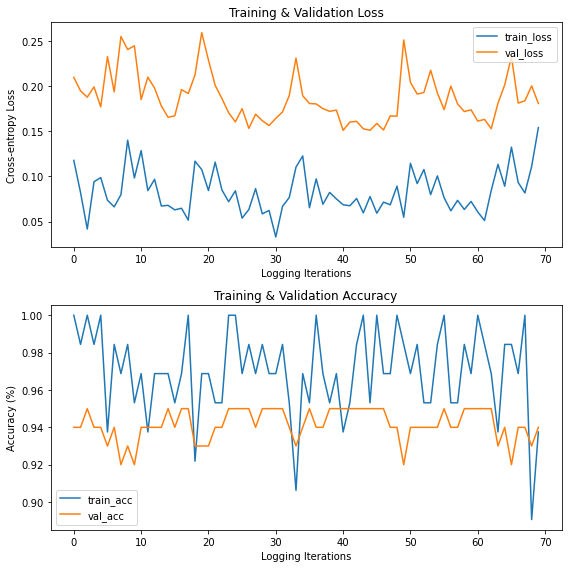

In [90]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.title("Training & Validation Loss")
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.ylabel("Cross-entropy Loss")
plt.xlabel("Logging Iterations")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Training & Validation Accuracy")
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.ylabel("Accuracy (%)")
plt.xlabel("Logging Iterations")
plt.legend()
plt.tight_layout()

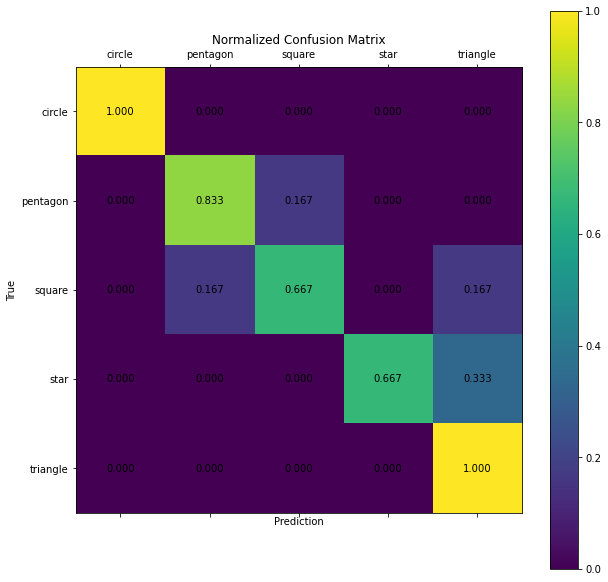

In [91]:
from sklearn.metrics import confusion_matrix

it = iter(test_loader) 

x, y = next(it)

outputs = model(x)
_, y_pred = torch.max(outputs, 1)

np.set_printoptions(precision=4)
plt.figure(figsize = (10,10))
cm = confusion_matrix(y.numpy(), y_pred.numpy(), normalize="true")
plt.matshow(cm, fignum=1)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
    
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel("Prediction")
plt.ylabel("True")

classes = test_data.class_to_idx
plt.gca().set_xticklabels(classes)
plt.gca().set_yticklabels(classes)

plt.title("Normalized Confusion Matrix")
plt.colorbar()
plt.show()